# Tarea KMeans y Shap
## Arantza Gomez Haro Gamboa

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
    
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="rosybrown")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="cornflowerblue")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

### **Datos**

In [3]:
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [4]:
target = 'Survived'
y = df[target]
X = df.copy()
X = X.drop(target, axis = 1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **XGBoost**

In [6]:
model = XGBClassifier(
    n_estimators = 100_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40,
    eval_metric = "auc"
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-auc:0.84905	validation_1-auc:0.79799


[70]	validation_0-auc:0.97621	validation_1-auc:0.87267


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [18:29:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_by_tree=0.8, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100000, n_jobs=None, ...)

#### *AUC:*

In [7]:
predicciones_xg = model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones_xg, y_true=y_test)

0.8856372295862742

#### *Gráfica de Calibración:*

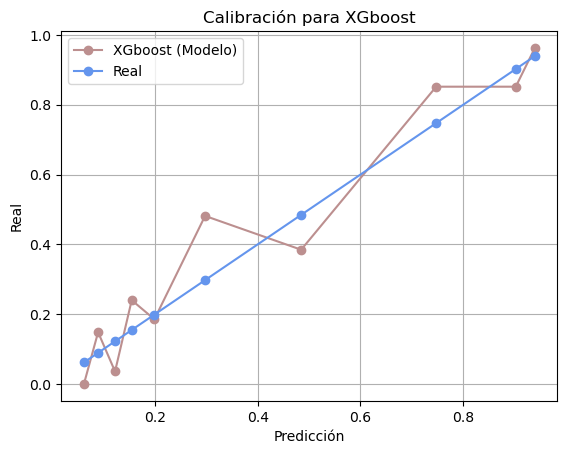

In [13]:
modelo = {
    'XGboost': predicciones_xg,
}

calibracion_multiple(modelo, y_test, bins=10)

#### *Feature Importance:*

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

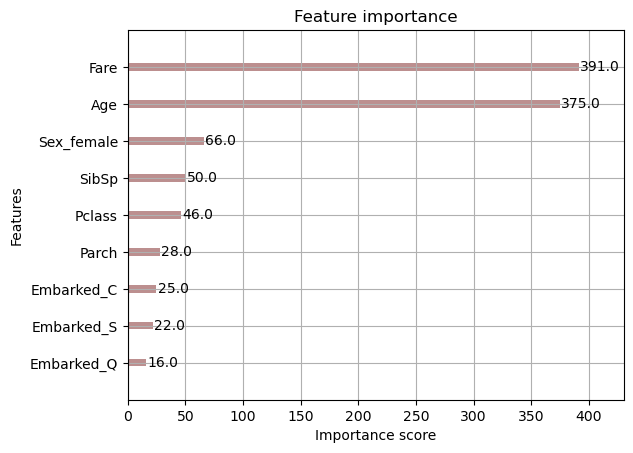

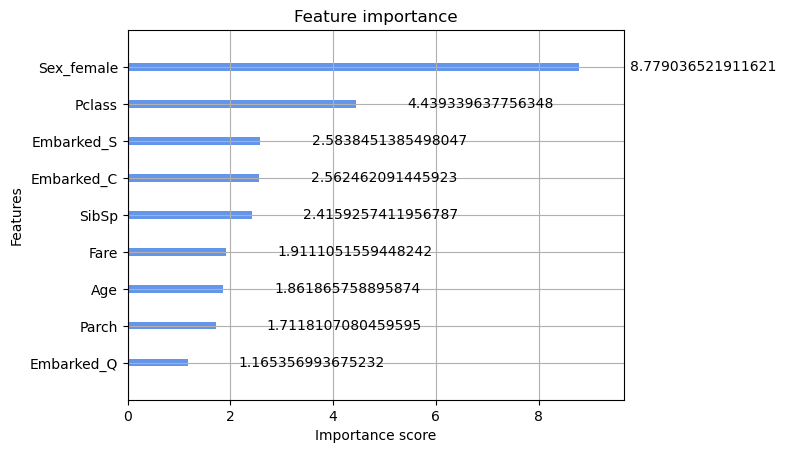

In [20]:
plot_importance(model, max_num_features=10, importance_type="weight", color = 'rosybrown')
plot_importance(model, max_num_features=10, importance_type="gain", color = 'cornflowerblue')

##### *Análisis:*

- 